In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import itertools
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf


In /Users/joseangelvelasco/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/joseangelvelasco/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/joseangelvelasco/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/joseangelvelasco/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/josean

[Source](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)

Time Series (referred as TS from now) is considered to be one of the less known skills in the analytics space (Even I had little clue about it a couple of days back).

1) What makes Time Series Special?

2) Loading and Handling Time Series in Pandas

3) How to Check Stationarity of a Time Series?

4) How to make a Time Series Stationary?

5) Forecasting a Time Series

## 1) What makes Time Series Special?

As the name suggests, TS is a collection of data points collected at constant time intervals. These are analyzed to determine the long term trend so as to forecast the future or perform some other form of analysis. But what makes a TS different from say a regular regression problem? There are 2 things:

* It is time dependent. So the basic assumption of a linear regression model that the observations are independent doesn’t hold in this case.
* Along with an increasing or decreasing trend, most TS have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, if you see the sales of a woolen jacket over time, you will invariably find higher sales in winter seasons.





## 2) Loading and Handling Time Series in Pandas

Pandas has dedicated libraries for handling TS objects, particularly the datatime64[ns] class which stores time information and allows us to perform some operations really fast. Lets start by firing up the required libraries:

In [2]:
%cd ..

/Users/joseangelvelasco/GoogleDrive/thesis/timeseries/time_series_analysis


In [4]:
df = pd.read_csv('data/REE_profiles.csv')
date = []
for k in range(0,len(df)):
    date.append(pd.Timestamp(int(df.date[k][0:4]), int(df.date[k][5:7]), int(df.date[k][8:10]), int(df.date[k][11:13]))) 
df = df.drop(['date','season'],axis=1)
df['date'] = date
df = df.set_index('date')
df = df.resample('D').mean()
df = df*100000
df.head()


,coef_a,coef_b,coef_c,coef_d
date,,,,
2013-01-01,12.227158,13.844726,7.927525,10.799492
2013-01-02,11.449340,13.017518,14.153724,11.972077
2013-01-03,12.140194,14.042226,14.846116,12.305393
2013-01-04,12.205815,14.194897,14.829594,12.340146
2013-01-05,13.239117,16.318806,9.900899,12.511061


In [5]:
print(df.dtypes)

coef_a    float64
coef_b    float64
coef_c    float64
coef_d    float64
dtype: object


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2130 entries, 2013-01-01 to 2018-10-31
Freq: D
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   coef_a  2130 non-null   float64
 1   coef_b  2130 non-null   float64
 2   coef_c  2130 non-null   float64
 3   coef_d  2130 non-null   float64
dtypes: float64(4)
memory usage: 83.2 KB


In [9]:
ts1 = df.coef_a
ts2 = df.coef_b
ts3 = df.coef_c
ts4 = df.coef_d

## 3. How to Check Stationarity of a Time Series?

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. But why is it important? Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

1) constant mean

2) constant variance

3) An autocovariance that does not depend on time.

Lets move onto the ways of testing stationarity. 

First and foremost is to simple plot the data and analyze visually. The data can be plotted using following command:

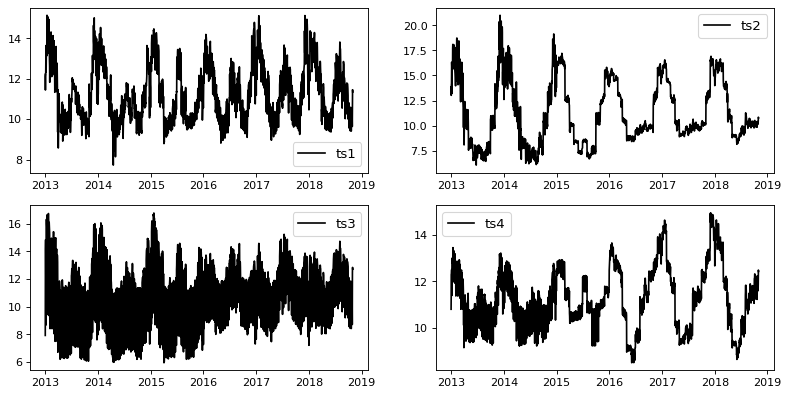

In [10]:
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(ts1,'k')
ax1.legend(('ts1',),fontsize=12)

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(ts2,'k')
ax2.legend(('ts2',),fontsize=12)

ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(ts3,'k')
ax3.legend(('ts3',),fontsize=12)

ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(ts4,'k')
ax4.legend(('ts4',),fontsize=12)

plt.show()

It is clearly evident that there is an overall decreasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences (we’ll see such cases later). So, more formally, we can check stationarity using the following:

1) __Plotting Rolling Statistics__: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

2) __Dickey-Fuller Test__: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

These concepts might not sound very intuitive at this point. I recommend going through the prequel article. If you’re interested in some theoretical statistics, you can refer Introduction to Time Series and Forecasting by Brockwell and Davis. The book is a bit stats-heavy, but if you have the skill to read-between-lines, you can understand the concepts and tangentially touch the statistics.

Back to checking stationarity, we’ll be using the rolling statistics plots along with Dickey-Fuller test results a lot so I have defined a function which takes a TS as input and generated them for us. Please note that I’ve plotted standard deviation instead of variance to keep the unit similar to mean.

In [137]:
ts = ts4

In [138]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

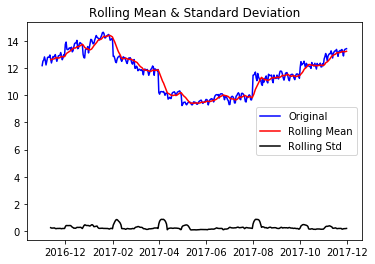

Results of Dickey-Fuller Test:
Test Statistic                  -1.051757
p-value                          0.733922
#Lags Used                      14.000000
Number of Observations Used    380.000000
Critical Value (1%)             -3.447676
Critical Value (5%)             -2.869176
Critical Value (10%)            -2.570838
dtype: float64


In [139]:
test_stationarity(ts)

the variation in standard deviation reduced, and mean is clearly decreasing with time and this so is not a stationary series. 

Also, the test statistic is way more than the critical values. Note that the signed values should be compared and not the absolute values.

Next, we’ll discuss the techniques that can be used to take this TS towards stationarity.

## 4. How to make a Time Series Stationary?

Though stationarity assumption is taken in many TS models, almost none of practical time series are stationary. So statisticians have figured out ways to make series stationary, which we’ll discuss now. Actually, its almost impossible to make a series perfectly stationary, but we try to take it as close as possible.

Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:

1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.

2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

Note: I’ll be discussing a number of methods. Some might work well in this case and others might not. But the idea is to get a hang of all the methods and not focus on just the problem at hand.

Let’s start by working on the trend part.



### Estimating & Eliminating Trend

One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

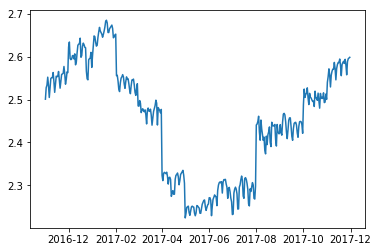

In [140]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

In this simpler case, it is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

- Aggregation – taking average for a time period like monthly/weekly averages

- Smoothing – taking rolling averages

- Polynomial Fitting – fit a regression model

I will discuss smoothing here and you should try other techniques as well which might work out for other problems. Smoothing refers to taking rolling estimates, i.e. considering the past few instances. There are can be various ways but I will discuss two of those here.

### Moving average

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.

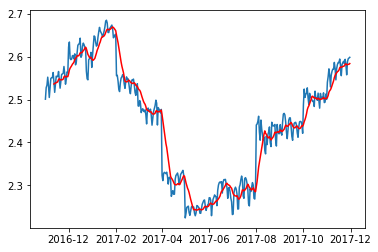

In [141]:
moving_avg = pd.Series.rolling(ts_log,12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
plt.show()

The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values. This can be observed as:

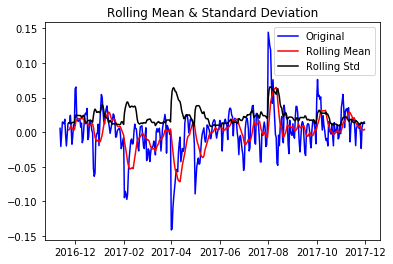

Results of Dickey-Fuller Test:
Test Statistic                  -4.291981
p-value                          0.000459
#Lags Used                      14.000000
Number of Observations Used    369.000000
Critical Value (1%)             -3.448197
Critical Value (5%)             -2.869405
Critical Value (10%)            -2.570960
dtype: float64


In [142]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True) # drop NaN values 
test_stationarity(ts_log_moving_avg_diff)# check the plots to test stationarity.

This looks like a much better series. The rolling values appear to be varying slightly but there is no specific trend. 

However, the test statistic is bigger than the 5% critical values so we can't say with 95% confidence that this is a stationary series.

However, a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor. Find details here. This can be implemented in Pandas as:

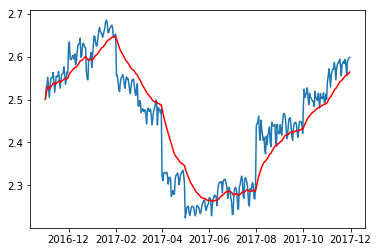

In [143]:
expwighted_avg = pd.Series.ewm(ts_log, halflife=12).mean()

plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
plt.show()

Note that here the parameter ‘halflife’ is used to define the amount of exponential decay. This is just an assumption here and would depend largely on the business domain. Other parameters like span and center of mass can also be used to define decay which are discussed in the link shared above. Now, let’s remove this from series and check stationarity:

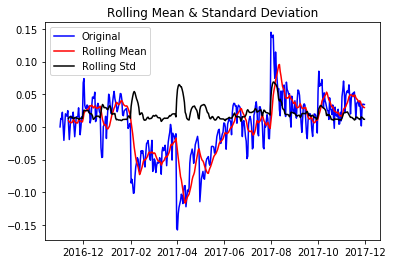

Results of Dickey-Fuller Test:
Test Statistic                  -2.314101
p-value                          0.167460
#Lags Used                      14.000000
Number of Observations Used    380.000000
Critical Value (1%)             -3.447676
Critical Value (5%)             -2.869176
Critical Value (10%)            -2.570838
dtype: float64


In [144]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

This TS has bigger variations in mean and standard deviation in magnitude.

However, the test statistic is smaller than the 1% critical value, which is better than the previous case. Note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

### Eliminating Trend and Seasonality

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

1) Differencing – taking the differece with a particular time lag

2) Decomposition – modeling both trend and seasonality and removing them from the model.



__Differencing__ 

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:

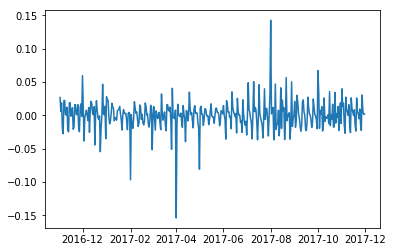

In [145]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

This appears to have reduced trend considerably. Lets verify using our plots:

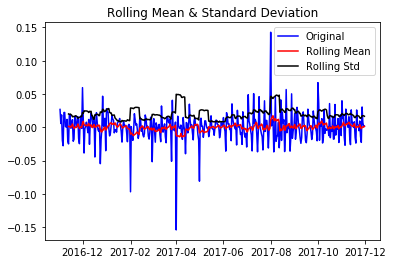

Results of Dickey-Fuller Test:
Test Statistic                  -5.097466
p-value                          0.000014
#Lags Used                      13.000000
Number of Observations Used    380.000000
Critical Value (1%)             -3.447676
Critical Value (5%)             -2.869176
Critical Value (10%)            -2.570838
dtype: float64


In [146]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

We can see that the mean and std variations have small variations with time. 

But, the Dickey-Fuller test statistic is greater than the 10% critical value, thus the TS is not stationary with 90% confidence.

We can also take second or third order differences which might get even better results in certain applications. I leave it to you to try them out.

__Decomposing__

In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned. I’ll skip the statistics and come to the results:

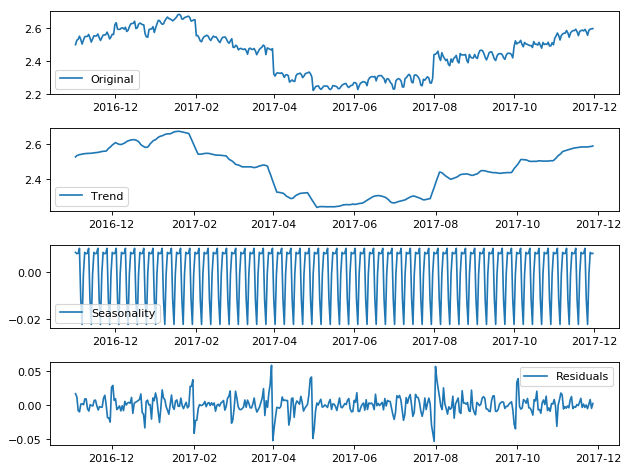

In [147]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend, seasonality are separated out from data and we can model the residuals. Lets check stationarity of residuals:

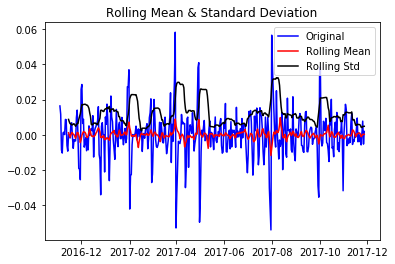

Results of Dickey-Fuller Test:
Test Statistic                -8.139283e+00
p-value                        1.038659e-12
#Lags Used                     1.600000e+01
Number of Observations Used    3.720000e+02
Critical Value (1%)           -3.448052e+00
Critical Value (5%)           -2.869341e+00
Critical Value (10%)          -2.570926e+00
dtype: float64


In [148]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value.

So this TS is very close to stationary. You can try advanced decomposition techniques as well which can generate better results. Also, you should note that converting the residuals into original values for future data in not very intuitive in this case.

## 5. Forecasting a Time Series

We saw different techniques and all of them worked reasonably well for making the TS stationary. Lets make model on the TS after differencing as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:

1) A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.

2) A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

Let me give you a brief introduction to __ARIMA__. I won’t go into the technical details but you should understand these concepts in detail if you wish to apply them more effectively. ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

* __Number of AR (Auto-Regressive) terms__ __(p)__: AR terms are just lags of dependent variable. For instance if p is 5, the predictors for $$x(t) = x(t-1)….x(t-5)$$.

* __Number of MA (Moving Average) terms__ __(q)__: MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for $$x(t) = e(t-1)….e(t-5)$$ where e(i) is the difference between the moving average at ith instant and actual value.

* __Number of Differences__ __(d)__: These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

* __Autocorrelation Function (ACF)__: It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).


* __Partial Autocorrelation Function (PACF)__: This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.
The ACF and PACF plots for the TS after differencing can be plotted as:

In [149]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [174]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

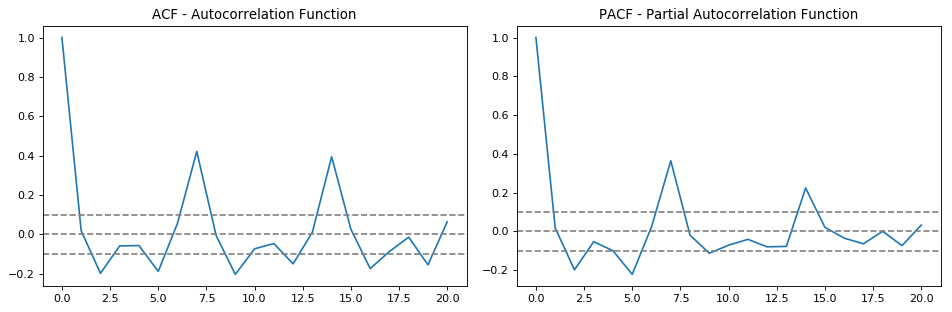

In [175]:
#Plot ACF: 
plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('ACF - Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('PACF - Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

1) __p__ – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.

2) __q__ – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

Now, lets make 3 different ARIMA models considering individual as well as combined effects. I will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.

We need to load the ARIMA model first:

In [152]:
from statsmodels.tsa.arima_model import ARIMA

The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). Let model the 3 cases:

## AR Model

/Users/joseangelvelasco/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/joseangelvelasco/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/joseangelvelasco/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr

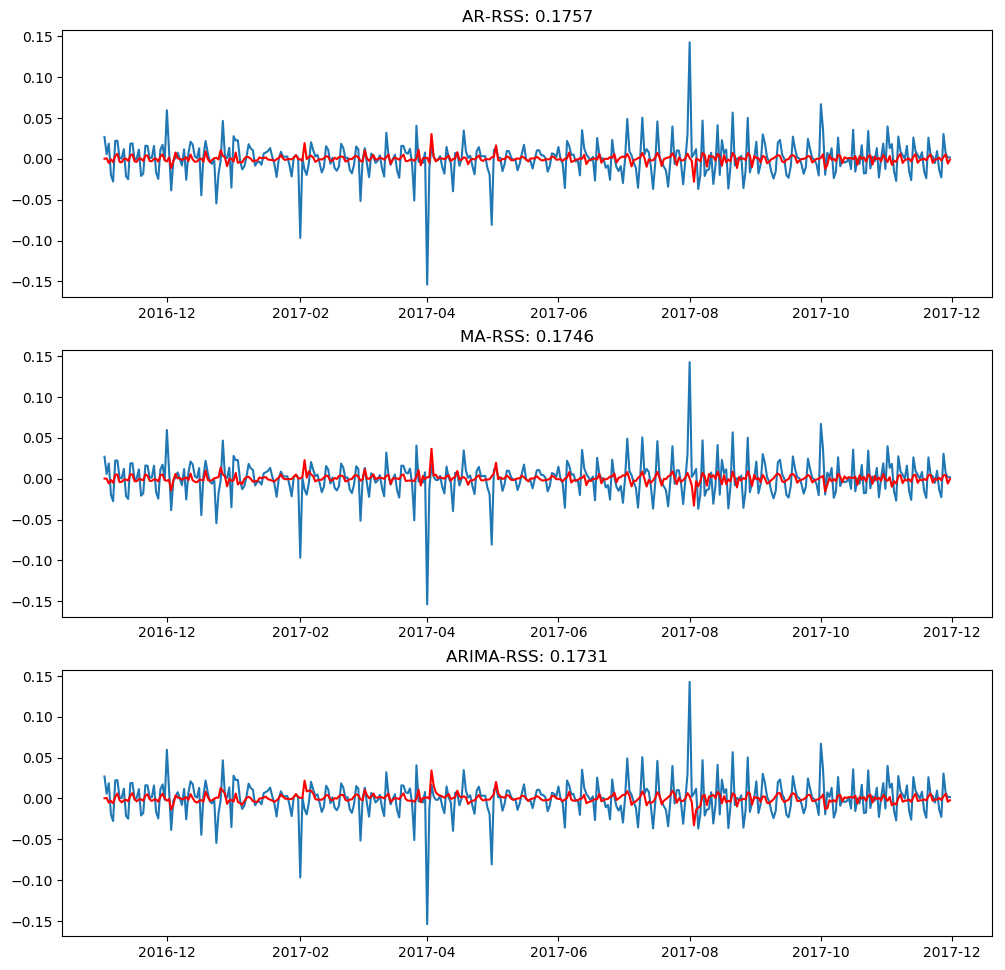

In [153]:
# AR Model
model_AR = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model_AR.fit(disp=-1)  
# MA Model
model_MA = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model_MA.fit(disp=-1)  
# Combined Model
model_ARIMA = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model_ARIMA.fit(disp=-1)  



fig = plt.figure(num=None, figsize=(12, 12), dpi=100, facecolor='w', edgecolor='k')

ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(ts_log_diff)
ax1.plot(results_AR.fittedvalues, color='red')
ax1.set_title('AR-RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(ts_log_diff)
ax2.plot(results_MA.fittedvalues, color='red')
ax2.set_title('MA-RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(ts_log_diff)
ax3.plot(results_ARIMA.fittedvalues, color='red')
ax3.set_title('ARIMA-RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

plt.show()



Here we can see that the AR and MA models have almost the same RSS but combined is significantly better. Now, we are left with 1 last step, i.e. taking these values back to the original scale.

## Taking it back to original scale

Since the combined model gave best result, lets scale it back to the original values and see how well it performs there. First step would be to store the predicted results as a separate series and observe it.

In [154]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
2016-11-02    0.000211
2016-11-03    0.000667
2016-11-04   -0.005201
2016-11-05   -0.002905
2016-11-06   -0.005799
Freq: D, dtype: float64


Notice that these start from 2016-11-02 and not the first day. Why? This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [155]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

date
2016-11-02    0.000211
2016-11-03    0.000877
2016-11-04   -0.004324
2016-11-05   -0.007229
2016-11-06   -0.013028
Freq: D, dtype: float64


You can quickly do some back of mind calculations using previous output to check if these are correct. Next we’ve to add them to base number. For this lets create a series with all values as base number and add the differences to it. This can be done as:

In [156]:
predictions_ARIMA_log = pd.Series(ts_log[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

date
2016-11-01    2.500871
2016-11-02    2.501082
2016-11-03    2.501749
2016-11-04    2.496547
2016-11-05    2.493642
Freq: D, dtype: float64

Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series

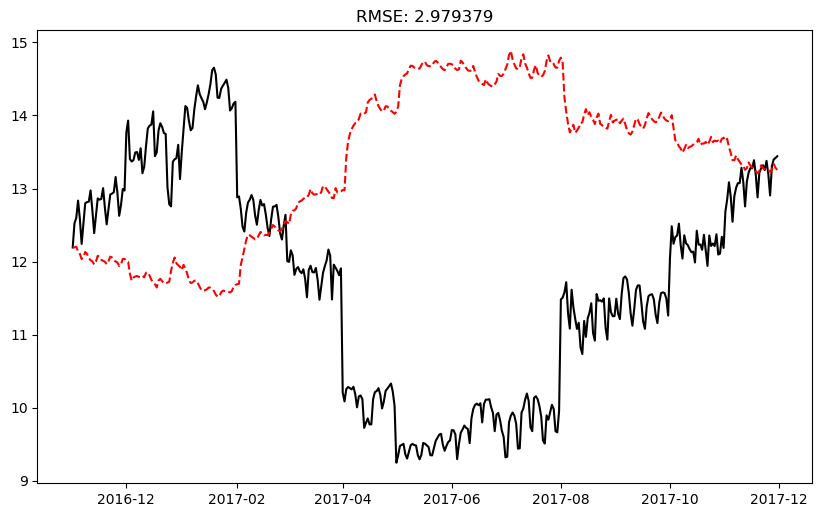

In [171]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

plt.figure(num=None, figsize=(10, 6), dpi=100, facecolor='w', edgecolor='k')
plt.plot(ts,'k-')
plt.plot(predictions_ARIMA,'r--')
plt.title('RMSE: %.6f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
plt.show()

Finally we have a forecast at the original scale. Not a very good forecast I would say but you got the idea right? Now, I leave it upto you to refine the methodology further and make a better solution.